# Introduction

In [59]:
import os
import sys
import csv
import datetime
import umap
import pandas as pd
import xgboost as xgb
import keras
import sklearn
import tensorflow
import numpy as np
import joblib
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from tsfresh import extract_features
from keras.models import Model, load_model
from keras.layers import Input, Activation, Dense, concatenate, LSTM, GRU, Dropout
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from random import uniform, randint

ContextualVersionConflict: (numba 0.36.2 (/anaconda3/lib/python3.6/site-packages), Requirement.parse('numba>=0.37'), {'umap-learn'})

# Data Importation

In [2]:
dfx = pd.read_csv('../data/x_train.csv').set_index('ID')
dfy = pd.read_csv('../data/y_train.csv').set_index('ID')
dfx_test = pd.read_csv('../data/x_test.csv').set_index('ID')

In [3]:
dfy.head()
dfx.tail()

,neuron_id,timestamp_0,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6,timestamp_7,timestamp_8,...,timestamp_40,timestamp_41,timestamp_42,timestamp_43,timestamp_44,timestamp_45,timestamp_46,timestamp_47,timestamp_48,timestamp_49
ID,,,,,,,,,,,,,,,,,,,,,
16630,5691,0.077914,0.708334,1.009554,1.125147,1.271336,1.299890,1.666290,1.718390,2.381562,...,29.316422,30.307006,31.185741,31.227892,32.320902,32.701000,32.955075,33.016627,34.837705,34.874491
16631,2341,0.485287,0.870193,0.959064,1.733133,1.755243,1.803468,1.841432,1.986925,2.006145,...,17.151013,17.367892,17.727558,18.178916,18.521734,19.492522,19.515122,20.715555,21.217199,21.640693
16632,8046,0.213619,0.290771,1.575419,1.650658,1.700773,1.856047,1.927563,1.950001,2.367852,...,14.064862,14.092407,14.343008,14.428562,14.671081,14.791297,14.847738,14.916361,15.055357,15.192531
16633,6855,2.669642,7.500198,8.710341,8.724346,8.760471,8.770804,8.786001,8.847625,8.885186,...,15.555430,15.698512,15.782122,16.067267,16.499324,16.906955,17.444176,18.704728,22.082864,27.185064
16634,6921,0.075924,0.376280,0.445379,0.762095,0.929728,1.029945,1.622643,1.710542,2.046901,...,23.397511,23.437452,24.217391,24.519848,24.675594,24.764713,24.894686,25.041824,25.071265,28.288743


In [4]:
if dfy.shape[0] == dfx.shape[0]:
    print("Same number of samples, all good.")
else:
    print("Different number of samples, problem!")

Same number of samples, all good.


# Data Exploration

* **Sanity check:** diff etat1/etat2, neuron_id usefulness

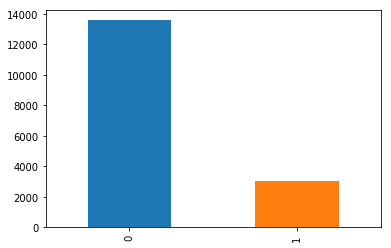

In [5]:
# Différence entre le nombre d'etats 1 et d'etats 0.
dfy.TARGET.value_counts().plot(kind='bar')
plt.show()

In [6]:
# Should we keep the neuron_id col ?
xtest_uniques = dfx_test.neuron_id.unique()
x_uniques = dfx.neuron_id.unique()
diff = [x for x in x_uniques if x in xtest_uniques]
print("There are {} neuron_ids in common between the train and test sets.".format(len(diff)))

There are 1 neuron_ids in common between the train and test sets.


In [7]:
dfx.neuron_id.unique().shape

(458,)

* **Balance dataset:** Under-sample class2 to have same number of samples in both classes

In [8]:
# SET SEED pour reproducibilité
def balance_data(X, y, method="undersampling", split=1):
    """ Return balanced training dataset obtained by undersampling class 2. """
    # Extract class2 indices from Y
    y_class1_ix = np.where(y == 1)[0]
    y_class2_ix = np.where(y == 0)[0]

    # Under-sample class2 to get balanced classes
    if method == "undersampling":
        y_class2_ix = np.random.choice(y_class2_ix, int(len(y_class1_ix) * split), replace=False)
    else:
        y_class2_ix = np.random.choice(y_class2_ix, int(len(y_class2_ix) * split), replace=False)

    # Split train & val
    y_class1_ix = np.random.choice(y_class1_ix, int(len(y_class1_ix) * split), replace=False)

    # Concatenate the undersampled_class2_array and the class1_array
    balanced_ix = np.concatenate((y_class1_ix, y_class2_ix), axis=0)
    np.random.shuffle(balanced_ix)

    # Create X_train dataset (Keras will do the val split)
    X_train = X[balanced_ix]
    y_train = y[balanced_ix]

    if method == "oversampling":
        X_train = np.reshape(X_train, X_train.shape[:2])
        ros = RandomOverSampler(random_state=0)
        X_train, y_train = ros.fit_sample(X_train, y_train)
        X_train = X_train[..., np.newaxis]
    
    # Create **UNOFFICIAL** X_val containing only 0s.
    balanced_ix_val = np.in1d(range(X.shape[0]), balanced_ix)
    
    X_val = X[~balanced_ix_val]
    y_val = y[~balanced_ix_val]
    
    return X_train, y_train, X_val, y_val

* **Extract features:** Use tsfresh to perform feature engineering

In [9]:
# WIP !
def extract_tsfresh(dfx):
    dfx = pd.DataFrame(dfx.stack(), columns=['spike_time']).reset_index()
    extracted_features = extract_features(dfx, column_id="ID", column_value="spike_time", column_sort="level_1")
    dfx = dfx.pivot(index='ID', columns='level_1', values='spike_time')
    dfx.columns = [int(col[col.find('_') + 1:]) for col in dfx.columns]
    dfx = dfx.sort_index(axis=1).join(extracted_features)
    dfx = dfx.dropna(axis='columns')
    fname = "../data/features{}.csv".format(datetime.datetime.now().strftime("%m%d%H%M%S"))
    dfx.to_csv(fname, sep=',')
    return dfx

In [10]:
def get_save(fn):
    save = pd.read_csv(fn)
    save = save.dropna(axis='columns').set_index('ID')
    return save

In [11]:
def isolate_features(X):
    ts_arr = X[:,:50]
    fe_arr = X[:,50:]
    fe_arr = np.reshape(fe_arr, fe_arr.shape[:-1])
    """
    Obsolete: repeat engineered features for each 50 timestep of a sample
    X = np.concatenate((np.repeat(features_arr.transpose(0,2,1), 50, axis=1), nofeat_arr), axis=2)
    !!! Will kill 42's mac !!!
    """
    return list((ts_arr, fe_arr))

In [12]:
def remove_low_var(fe_arr, step="test"):
    if step == "train":
        fe_arr = sel.fit_transform(fe_arr)
    else:
        fe_arr = sel.transform(fe_arr)
    return fe_arr

In [13]:
def drop_unique_col(df):
    for col in df.columns:
        if len(df[col].unique()) == 1:
            df.drop(col,inplace=True,axis=1)

* **Standardization:** Scale features

In [14]:
def standardize_data(X, step="test"):
    """Simple standardization that accepts both a single arr, AND 2 arrays in case of RNN+FeatureEngineering"""
    def standardize(X, step):
        if step == "train":
            X = scaler.fit_transform(X)
        else:
            X = scaler.transform(X)
        #X -= np.mean(X, axis=0)
        #X /= (np.std(X, axis=0) + sys.float_info.epsilon)
        #X = np.nan_to_num(X)
        return X

    if isinstance(X, list):
        X = (X[0], standardize(X[1], step))
#    else:
#        X = standardize(X, step)
    return X

* **Create Xtrain ytrain:** numpy array from df, with dimensions *(sample_nb, timestep_nb, feature_nb)*

In [15]:
def getData(dfx, dfy, 
            exclude_neuron_id=True, 
            balancing="undersample",
            standardize=False,
            differencing=False,
            get_tsfresh=False,
            get_ISI_SPIKE=False,
            step="train",
            RNN=True,
            remove_low_variance=True,
            split=0.90,
            **extras):    
   
    if isinstance(dfx, str) and get_tsfresh:
        dfx = get_save(dfx)
        #drop_unique_col(dfx)
    else:
        if exclude_neuron_id:
            # X: Exclude neuron_id column from array
            dfx = dfx.drop(columns=['neuron_id'])
        if get_tsfresh:
            dfx = extract_tsfresh(dfx)
    
    X = dfx.values
    
    X = X[..., np.newaxis]
    y = np.reshape(dfy.values, (dfy.values.shape[0],))
       
    if step != "test":
        X, y, X_val, y_val = balance_data(X, y, method=balancing, split=split)
    else:
        X_val = np.ones(X.shape)
        y_val = np.ones(y.shape)
        
    # Convert from timeseries to interval
    if differencing:
        X[:,1:50] -= X[:,:49]
        X_val[:,1:50] -= X_val[:,:49]
 
    if get_ISI_SPIKE:
        pass
    
    if get_tsfresh:
        X = isolate_features(X)
        X_val = isolate_features(X_val)
    
    if get_tsfresh and remove_low_variance:
        X[1] = remove_low_var(X[1], step)
        if step != "test":
            # Otherwise X_val is a made up np.ones array and has 0 variance => BUG
            X_val[1] = remove_low_var(X_val[1])
        
#    elif get_tsfresh:
#        X = np.reshape(X, X.shape[:2])
        
    if standardize:
        X = standardize_data(X, step)
        if step != "test":
            # Same as before
            X_val = standardize_data(X_val)
      
    return X, y, X_val, y_val

* **Deprecated:** Concatenate neuron_id to every timestep of a sample 

In [16]:
# TODO : Make a 3d numpy array from our pandas df
# Shape = [samples, timestamps, features]
"""
timesteps_arr = dfx.iloc[:,1:].values
timesteps_arr = timesteps_arr[..., np.newaxis]
timesteps_arr.shape

neuron_arr = dfx.iloc[:,0].values
neuron_arr.shape

neuron_arr = np.broadcast_to(neuron_arr[:,None,None], timesteps_arr.shape)
final_arr = np.concatenate((timesteps_arr,neuron_arr), axis=2)
final_arr.shape
"""

'\ntimesteps_arr = dfx.iloc[:,1:].values\ntimesteps_arr = timesteps_arr[..., np.newaxis]\ntimesteps_arr.shape\n\nneuron_arr = dfx.iloc[:,0].values\nneuron_arr.shape\n\nneuron_arr = np.broadcast_to(neuron_arr[:,None,None], timesteps_arr.shape)\nfinal_arr = np.concatenate((timesteps_arr,neuron_arr), axis=2)\nfinal_arr.shape\n'

# Model Training

## References

* Arxiv: [Neural activity classification with machine learning models trained oninterspike interval series data](https://arxiv.org/pdf/1810.03855.pdf) => PCA and KNN
* Github: [PySpike: Python library to analyze spike Train](https://github.com/mariomulansky/PySpike) => Obscure mathematical measurements between spike trains
* Profil: [Prof expert en spike train analysis](http://xtof.perso.math.cnrs.fr/)

## Prepare experiment

In [17]:
np.random.seed(42)
tensorflow.set_random_seed(2)

In [18]:
params = {
    'name': "XGB_Daddycool",
    'exclude_neuron_id': True,
#    'balancing': None,
    'balancing': None,
    'standardize': True,
    'differencing': True,
    'get_tsfresh': True,
    'get_ISI_SPIKE': False,
    'RNN': False,
    'class_weight': True,
    'remove_low_variance': True,
    'dropout': 0.2,
    'batch_size': 32,
}

In [19]:
def process_data(params):
    global sel, scaler
    sel = sklearn.feature_selection.VarianceThreshold(threshold=.02)
    scaler = sklearn.preprocessing.StandardScaler()

    if params['get_tsfresh']:
        X = "../data/features0607182541.csv"
        X_test = "../data/features0607183651.csv"
    else:
        X = dfx
        X_test = dfx_test

    X_train, y_train, X_val, y_val = getData(X, dfy, step="train", **params)
    X_test, _, _, _ = getData(X_test, dfy, step="test", **params)
    return X_train, y_train, X_val, y_val, X_test

In [20]:
def predict(X_test, model):
    # Predict on custom X_test
    y_pred = model.predict(X_test)
    y_pred = np.reshape(y_pred, (y_pred.shape[0],))
    print (y_pred.shape)
    
    # Convert sigmoid output to 0s and 1s
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
  
    # Format .csv in ENS style
    dfy_pred = pd.DataFrame(data=y_pred, columns=["TARGET"], dtype=int)
    dfy_pred.index.name = "ID"
    dfy_pred.index += 16635
    return dfy_pred

In [21]:
def evaluate(y_true, y_pred):
    print(metrics.classification_report(y_true, y_pred))
    print(metrics.cohen_kappa_score(y_true, y_pred))

## Run training

### Deep-Learning 1: blunt RNN

In [22]:
X_train, y_train, X_val, y_val, X_test = process_data(params)

* **Create and train model**

In [27]:
if params['get_tsfresh']:
    timestep_nb = X_train[0].shape[1]
else:
    timestep_nb = X_train.shape[1]
spike_per_ts = 1
params['cell_nb'] = 256

input_tensor = Input(shape=(timestep_nb, spike_per_ts))
X = LSTM(params['cell_nb'], return_sequences=True, dropout=params['dropout'])(input_tensor)
X = LSTM(params['cell_nb'], return_sequences=False)(X)

if params['get_tsfresh']:
    additional_features = X_train[1].shape[1]
    fe_input = Input(shape=(additional_features,)) # A tensor containing the engineered features
    latent = Dense(64, activation='relu')(fe_input)
    latent = Dropout(rate=params['dropout'])(latent)
    latent = Dense(32, activation='relu')(latent)
    latent = Dropout(rate=params['dropout'])(latent)
    input_tensor = [input_tensor, fe_input]
    X = concatenate([X, latent])   
    
output_tensor = Dense(1, activation='sigmoid')(X)

model = Model(input_tensor, output_tensor)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 256)           264192    
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 789,761
Trainable params: 789,761
Non-trainable params: 0
_________________________________________________________________


In [24]:
if params["class_weight"]:
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
else:
    class_weights = None
if params["get_tsfresh"]:
    X_train=list(X_train)
model.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=5, validation_split=0.05, class_weight=class_weights, batch_size=params['batch_size'])

Train on 23216 samples, validate on 1222 samples
Epoch 1/5
23216/23216 [==============================] - 399s 17ms/step - loss: 0.2467 - acc: 0.5467 - val_loss: 0.2469 - val_acc: 0.6637
Epoch 2/5
23216/23216 [==============================] - 397s 17ms/step - loss: 0.2408 - acc: 0.5759 - val_loss: 0.2625 - val_acc: 0.7275
Epoch 3/5
23216/23216 [==============================] - 386s 17ms/step - loss: 0.2359 - acc: 0.5940 - val_loss: 0.1926 - val_acc: 0.8543
Epoch 4/5
23216/23216 [==============================] - 380s 16ms/step - loss: 0.2245 - acc: 0.6285 - val_loss: 0.1227 - val_acc: 0.8953
Epoch 5/5
23216/23216 [==============================] - 391s 17ms/step - loss: 0.2107 - acc: 0.6650 - val_loss: 0.1195 - val_acc: 0.8650


In [25]:
history_params = [
    ('batch_size', history.params['batch_size']),
    ('epochs', history.params['epochs']),
    ('samples', history.params['samples']),
    ('val_acc', history.history['val_acc'][-1])
    ]

params.update(history_params)

* **Evaluate**

In [26]:
if params["get_tsfresh"]:
    X_val=list(X_val)
dfy_val = predict(X_val, model)
evaluate(y_val, dfy_val)

(1664,)
             precision    recall  f1-score   support

          0       0.93      0.52      0.66      1358
          1       0.28      0.84      0.42       306

avg / total       0.81      0.57      0.62      1664

0.19895125626227295


* **Predict**

In [34]:
if params["get_tsfresh"]:
    X_test=list(X_test)
dfy_pred = predict(X_test, model)
dfy_pred[:15]

(11969,)


,TARGET
16635,1
16636,1
16637,0
16638,0
16639,1
16640,0
16641,1
16642,0
16643,0
16644,1


### Domain-knowledge 1: Benchmark = differencing + tsfresh feature engineering + XGB

In [22]:
"""
scores = []
for split in np.arange(0.2, 1, 0.1):
    params['split'] = split
    X_train, y_train, X_val, y_val, X_test = process_data(params)
    print(X_train[1].shape)
    model.fit(X_train[1], y_train)
    dfy_val = predict(X_val[1], model)
    scores.append((metrics.f1_score(y_val, dfy_val), metrics.cohen_kappa_score(y_val, dfy_val)))
"""

"\nscores = []\nfor split in np.arange(0.2, 1, 0.1):\n    params['split'] = split\n    X_train, y_train, X_val, y_val, X_test = process_data(params)\n    print(X_train[1].shape)\n    model.fit(X_train[1], y_train)\n    dfy_val = predict(X_val[1], model)\n    scores.append((metrics.f1_score(y_val, dfy_val), metrics.cohen_kappa_score(y_val, dfy_val)))\n"

In [23]:
X_train, y_train, X_val, y_val, X_test = process_data(params)

In [24]:
X_train[1].shape

(14971, 299)

* **Train XGB**

In [78]:
if params['class_weight']:
    scale_pos_weight = np.sum(y_train == 0)/ float(np.sum(y_train == 1))
else:
    scale_pos_weight = 1

In [79]:
#XGB
params_XGB = {
        'min_child_weight': 1,
        'gamma': 0.5,
        'subsample': 0.8,
        'colsample_bytree': 0.6,
        'max_depth': 10,
        'n_estimators': 200,
        'learning_rate': 0.05,
        'scale_pos_weight': scale_pos_weight
        }
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, **params_XGB)

#SVC
#model = SVC(gamma='auto')

In [83]:
params.update(model.get_params())
params_XGB = {
        'min_child_weight': [1],
        'gamma': [0.5, 1],
        'subsample': [0.8],
        'colsample_bytree': [0.6],
        'max_depth': [10]
        }
"""
#search = RandomizedSearchCV(model, param_distributions=params_CV, rchandom_state=42,
#                            n_iter=200, cv=3, verbose=1, n_jobs=4, return_train_score=True)
"""
search = RandomizedSearchCV(model, param_distributions=params_XGB, n_iter=1, scoring='roc_auc', n_jobs=4, 
                            verbose=3, random_state=1001 )

search.fit(select_X_train, y_train)

#model.fit(X_train[1], y_train, verbose=True)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] subsample=0.8, min_child_weight=1, max_depth=10, gamma=0.5, colsample_bytree=0.6 
[CV] subsample=0.8, min_child_weight=1, max_depth=10, gamma=0.5, colsample_bytree=0.6 
[CV] subsample=0.8, min_child_weight=1, max_depth=10, gamma=0.5, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=1, max_depth=10, gamma=0.5, colsample_bytree=0.6, score=0.6733275136172264, total=  13.0s
[CV]  subsample=0.8, min_child_weight=1, max_depth=10, gamma=0.5, colsample_bytree=0.6, score=0.6633023118705221, total=  13.2s
[CV]  subsample=0.8, min_child_weight=1, max_depth=10, gamma=0.5, colsample_bytree=0.6, score=0.6599734774926833, total=  13.5s


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   14.2s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.5, learning_rate=0.05,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=4.440043604651163, seed=None,
       silent=True, subsample=0.8),
          fit_params=None, iid=True, n_iter=1, n_jobs=4,
          param_distributions={'min_child_weight': [1], 'gamma': [0.5, 1], 'subsample': [0.8], 'colsample_bytree': [0.6], 'max_depth': [10]},
          pre_dispatch='2*n_jobs', random_state=1001, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=3)

In [84]:
best_xgb= search.best_estimator_

* **Train XGB**

In [85]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0, class_weight='balanced')

In [86]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [87]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
rf_random.fit(select_X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV] n_estimators=333, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=  12.4s
[CV] n_estimators=333, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=  12.5s
[CV] n_estimators=333, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=F

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.8min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [200, 266, 333, 400, 466, 533, 600, 666, 733, 800], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [89]:
best_random = rf_random.best_estimator_

* **Predict**

In [91]:
select_X_test = selection.transform(X_test[1])
dfy_pred = predict(select_X_test, best_random)

(11969,)


* **Evaluate**

In [92]:
select_X_val = selection.transform(X_val[1])
dfy_val = predict(select_X_val, best_random)
evaluate(y_val, dfy_val)

(1664,)
             precision    recall  f1-score   support

          0       0.85      0.94      0.89      1358
          1       0.49      0.25      0.33       306

avg / total       0.78      0.81      0.79      1664

0.2364152135305546


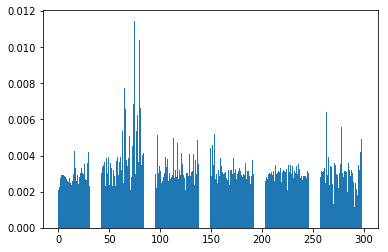

In [44]:
from matplotlib import pyplot
pyplot.bar(range(len(best_xgb.feature_importances_)), best_xgb.feature_importances_)
pyplot.show()

In [54]:
thresholds = sorted(best_xgb.feature_importances_)
thresh = thresholds[-20]
selection = sklearn.feature_selection.SelectFromModel(best_xgb, threshold=thresh, prefit=True)
select_X_train = selection.transform(X_train[1])

In [55]:
select_X_train.shape

(14971, 20)

### Domain-knowledge 2: KNN with SPIKE- and ISI- synchronization distances

## Save Results

In [94]:
def saveExp(dfy_pred, model, params):
    """ Create directory in which to save predictions, experiment parameters and model object. """

    directory = "../experiments/{}".format(datetime.datetime.now().strftime("%m%d%H%M%S"))
    if not os.path.exists(directory):
        os.makedirs(directory)

    dfy_pred.to_csv(directory + '/y_pred.csv', sep=',')
    
    joblib.dump(model, directory + '/model.h5')
    
    columns = []
    values = []
    for k, v in params.items():
        columns.append(k)
        values.append(v)
    params_df = pd.DataFrame(data=[values], columns=columns)
    params_df.to_csv(directory + '/params.csv', sep=';')
    return directory

# Save model
saveExp(dfy_pred, best_random, params)

'../experiments/0622164316'

## Load Model

In [301]:
def load_exp():
    """ Reproduce saved experience from a directory: load dataset, model, predict on x_test and evaluate. """
    
    for xp in os.scandir("../experiments"):
    
        if not xp.is_dir():
            continue
        
        model_path, params_path, y_pred_path = sorted(os.scandir(xp.path), key=lambda x: (x.is_dir(), x.name))
        model = load_model(model_path.path)
        model.summary()
        
        with open(params_path, mode='r') as infile:
            reader = csv.reader(infile, delimiter=';')
            keys, values = reader
        params = {keys[ix]:values[ix] for ix in range(len(keys))}
        for k, v in params.items():
            if v == 'True' or v == 'False':
                params[k] = v == 'True'
        X_train, y_train, X_val, y_val, X_test = process_data(params)
        if isinstance(X_train, tuple):
            print(X_train[0].shape)
        else:
            print(X_train.shape)
        print(params)
        
        dfy_val = predict(X_val, model)
        evaluate(model)
        
load_exp()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 50, 1)        0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 382)          0                                            
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 128)          66560       input_20[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 32)           12256       input_21[0][0]                   
__________________________________________________________________________________________________
concatenat

AttributeError: 'tuple' object has no attribute 'ndim'